# Tutorial on the usage of hydration

This tutorial will show how to use the hydration class to compute the solvation of polymers that belong to the same micelle.

Before starting any analysis, load the neccesary modules for this class.

In [34]:

from pysoftk.pol_analysis.tools.utils_mda import MDA_input

from pysoftk.pol_analysis.tools.utils_tools import *

from pysoftk.pol_analysis.clustering import SCP

from pysoftk.pol_analysis.make_micelle_whole import micelle_whole

from pysoftk.pol_analysis.solvation import solvation


import numpy as np
import pandas as pd

1. First load the trajectory, we are going to use the cyclic topology used in previous tutorials.

In [35]:
topology='data/cyclic_water_short_trajectory.tpr'
trajectory='data/cyclic_water_short_trajectory.xtc'


2. Import the clustering data from SCP function, to obtain the resids of the polymers of each micelle

In [36]:
resids_total='data/pictures_tutorial/cyclic_scp_result.parquet'

3. Obtain the largest micelle from the clustering pandas dataframe

In [37]:
largest_micelle_resids = micelle_whole(topology, trajectory).obtain_largest_micelle_resids(resids_total)

4. Now, obtain the positions of the whole micelle

In [38]:
#select the resname of the polymers
resname=['LIG']

#run to obtain the whole positions
start=0
stop=10001
step=1

#run micelle_whole
atom_pos = micelle_whole(topology, trajectory).running_make_cluster_whole(resname, largest_micelle_resids, start, stop, step)

  0%|                                                                                                                                                    | 0/3 [00:00<?, ?it/s]/home/raquellrdc/Desktop/PhD/pysoftk/alejandro_newest_releast_check/pysoftk_analysis_code/test_final/make_micelle_whole.py:347: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  atom_positions_over_trajectory = list(tqdm(map(self.make_cluster_whole, frames, resname, cluster_resids_f[0],
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]

Elapsed time for matrix calculation: 5.8799 seconds


5. Let's select the atoms for the solvation calculation and the cutoff distance

In [39]:
#atom names for the calculation
MA_oxygen_names = ['O00A', 'O00D', 'O00C', 'O01G', 'O01F', 'O01D', 'O01A', 'O019', 'O016', 'O015', 'O010', 'O012']

#cutoff distance-this can be obtained from radial distribution functions or just by intuition

cutoff=4.5

6. Also, we need to define the atoms of the solvent. In this case, it is water so we will select the oxygen heavy atoms. Just one atom per solvent molecule is enough for the calculation.

In [40]:
water_atoms=['OW']

7. We have all the neccesary inputs to run the contacts calculation

In [42]:

solvation = solvation(topology, trajectory).solvation_calc_run(start, stop, step, largest_micelle_resids, atom_pos, ['OW'], MA_oxygen_names, cutoff )
                                                                      

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.34s/it]


Bear in mind that the array 'solvation' contains the solvation data of all the MA_oxygen_names atoms over all polymers and over all time steps. The output is given like this for users to be able to play with the data and work with it in the way they want. However, to report the average over the polymers, it is neccesary to divide all values by the number of polymers in the micelle. And then the mean over the time steps to get the average value over the trajectory.

In [56]:
#to normalize the solvation depending on the number of polymers in the micelle in each time step

solvation_normalized=[]

for i in range(len(largest_micelle_resids)):
    
    len_micelle=len(largest_micelle_resids[i]) #number of polymers in the micelle at a specific time step
    
    solvation_normalized.append((np.array(solvation[i])/len_micelle)) #each solvation value is divided by the number of polymers in the micelle
    
solvation_normalized = np.array(solvation_normalized) #array with the solvation values normalized over polymer number


array([[1.86666667, 1.6       , 1.46666667, 1.2       , 0.46666667,
        0.46666667, 0.73333333, 0.13333333, 1.        , 0.8       ,
        0.8       , 1.6       ],
       [3.63636364, 2.        , 1.54545455, 1.36363636, 0.90909091,
        0.81818182, 1.        , 0.45454545, 1.54545455, 1.36363636,
        1.27272727, 2.81818182],
       [2.36363636, 2.54545455, 2.09090909, 2.18181818, 1.        ,
        0.90909091, 1.90909091, 1.18181818, 1.36363636, 0.90909091,
        1.36363636, 2.45454545]])

In [58]:
#average over time

mean_solvation=np.mean(solvation_normalized , axis=0)


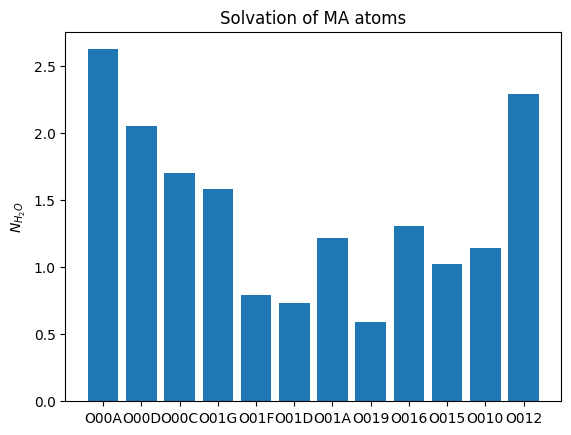

In [63]:
import matplotlib.pyplot as plt

plt.bar(range(len(mean_solvation)), mean_solvation) 
plt.xticks(np.arange(len(MA_oxygen_names)), MA_oxygen_names)
plt.ylabel('$N_{H_{2}O}$')
plt.title('Solvation of MA atoms')
plt.show()

This heatmap is a clear way to represent the contacts that each atom has with all the other atoms of the other group. In this case we calculated the contacts between atoms belonging to the MA names, but you can also calculate the contacts between atoms of different groups. It is as easy as feeding in two different groups of atom names to the contacts function